In [1]:
# pip install Keras-Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [8]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir

In [9]:
#Jumlah masuk data untuk diproses
BATCH_SIZE = 32

#Jumlah besar ukuran gambar
IMAGE_SIZE = (300, 300)

In [10]:
# dataset
dataset = "/Code/python jupyter/corn.maze leaf/data"
walk_through_dir(dataset);

There are 4 directories and 0 images in '/Code/python jupyter/corn.maze leaf/data'.
There are 0 directories and 1146 images in '/Code/python jupyter/corn.maze leaf/data\Blight'.
There are 0 directories and 1306 images in '/Code/python jupyter/corn.maze leaf/data\Common_Rust'.
There are 0 directories and 574 images in '/Code/python jupyter/corn.maze leaf/data\Gray_Leaf_Spot'.
There are 0 directories and 1162 images in '/Code/python jupyter/corn.maze leaf/data\Healthy'.


In [11]:
# file and category layout
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# combine file location and category
image_df = pd.concat([filepaths, labels], axis=1)

In [12]:
labels

0        Blight
1        Blight
2        Blight
3        Blight
4        Blight
         ...   
8369    Healthy
8370    Healthy
8371    Healthy
8372    Healthy
8373    Healthy
Name: Label, Length: 8374, dtype: object

In [13]:
image_df

Filepath    Label
0     \Code\python jupyter\corn.maze leaf\data\Bligh...   Blight
1     \Code\python jupyter\corn.maze leaf\data\Bligh...   Blight
2     \Code\python jupyter\corn.maze leaf\data\Bligh...   Blight
3     \Code\python jupyter\corn.maze leaf\data\Bligh...   Blight
4     \Code\python jupyter\corn.maze leaf\data\Bligh...   Blight
...                                                 ...      ...
8369  \Code\python jupyter\corn.maze leaf\data\Healt...  Healthy
8370  \Code\python jupyter\corn.maze leaf\data\Healt...  Healthy
8371  \Code\python jupyter\corn.maze leaf\data\Healt...  Healthy
8372  \Code\python jupyter\corn.maze leaf\data\Healt...  Healthy
8373  \Code\python jupyter\corn.maze leaf\data\Healt...  Healthy

[8374 rows x 2 columns]

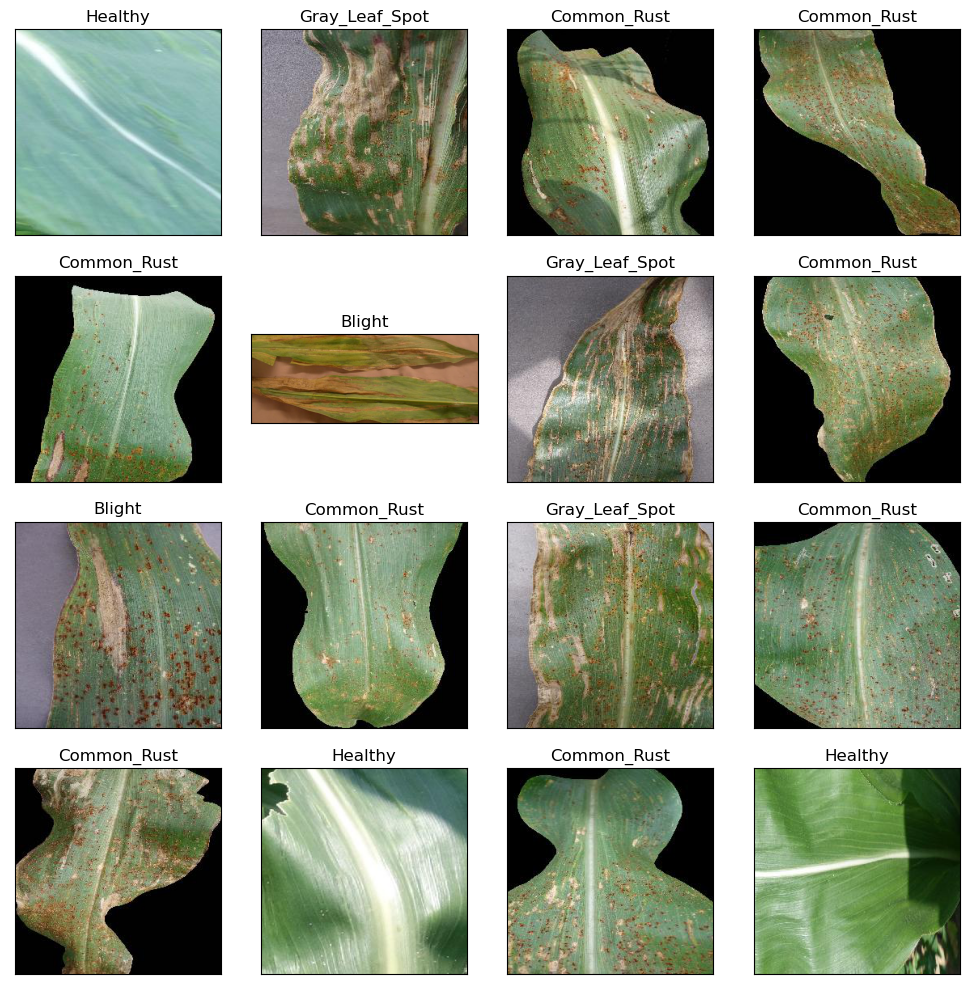

In [14]:
# Display random photos by category
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [15]:
# Separate training and testing data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [16]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
# Divide data into categories of data (train, val and test)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5360 validated image filenames belonging to 4 classes.
Found 1339 validated image filenames belonging to 4 classes.
Found 1675 validated image filenames belonging to 4 classes.


In [36]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
# Load the pretained model , the MOBILENETV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 30s 3us/step


In [20]:
# Create checkpoint callback
checkpoint_path = "disease_classification"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [21]:
# Earlystopping
early_stopping = EarlyStopping(monitor = "val_loss", 
                               patience = 5,
                               restore_best_weights = True) 

In [22]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "disease_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/disease_classification/20230819-132536
Epoch 1/50
168/168 [==============================] - 354s 2s/step - loss: 0.4815 - accuracy: 0.8164 - val_loss: 0.2411 - val_accuracy: 0.9104
Epoch 2/50
168/168 [==============================] - 294s 2s/step - loss: 0.2349 - accuracy: 0.9060 - val_loss: 0.1936 - val_accuracy: 0.9223
Epoch 3/50
168/168 [==============================] - 300s 2s/step - loss: 0.1878 - accuracy: 0.9257 - val_loss: 0.1743 - val_accuracy: 0.9328
Epoch 4/50
168/168 [==============================] - 349s 2s/step - loss: 0.1530 - accuracy: 0.9416 - val_loss: 0.1575 - val_accuracy: 0.9395
Epoch 5/50
168/168 [==============================] - 384s 2s/step - loss: 0.1283 - accuracy: 0.9541 - val_loss: 0.1583 - val_accuracy: 0.9440
Epoch 6/50
168/168 [==============================] - 373s 2s/step - loss: 0.1010 - accuracy: 0.9640 - val_loss: 0.1338 - val_accuracy: 0.9477
Epoch 7/50
168/168 [==============================] - 35

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [26]:
results = model.evaluate(test_images, verbose=0)
# get the loss
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06414
Test Accuracy: 97.73%


In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 2 predictions: {pred[:2]}')

53/53 [==============================] - 100s 2s/step
The first 2 predictions: ['Blight', 'Healthy']


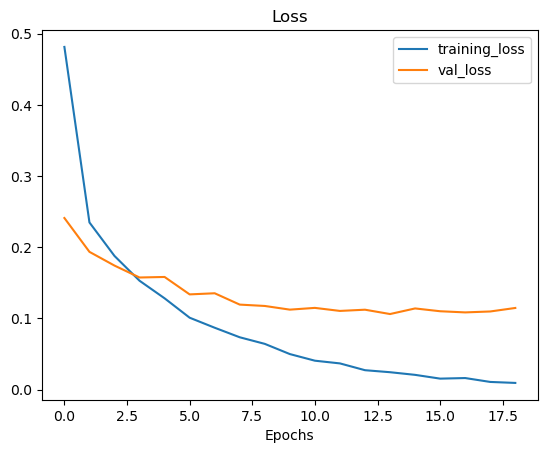

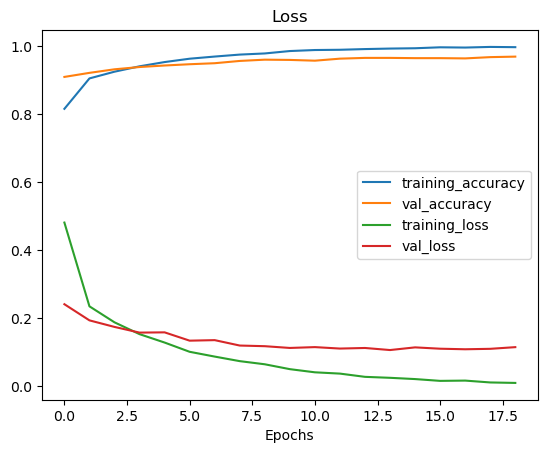

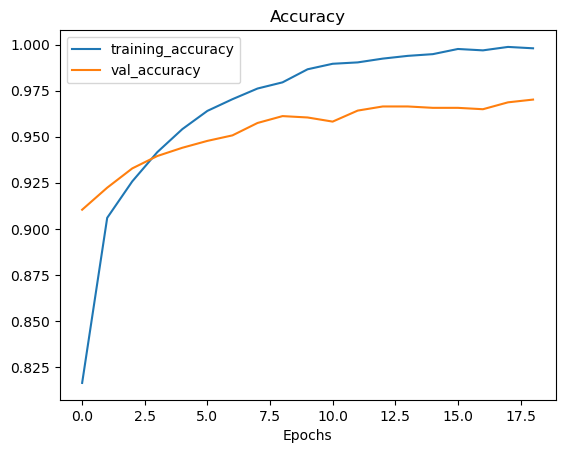

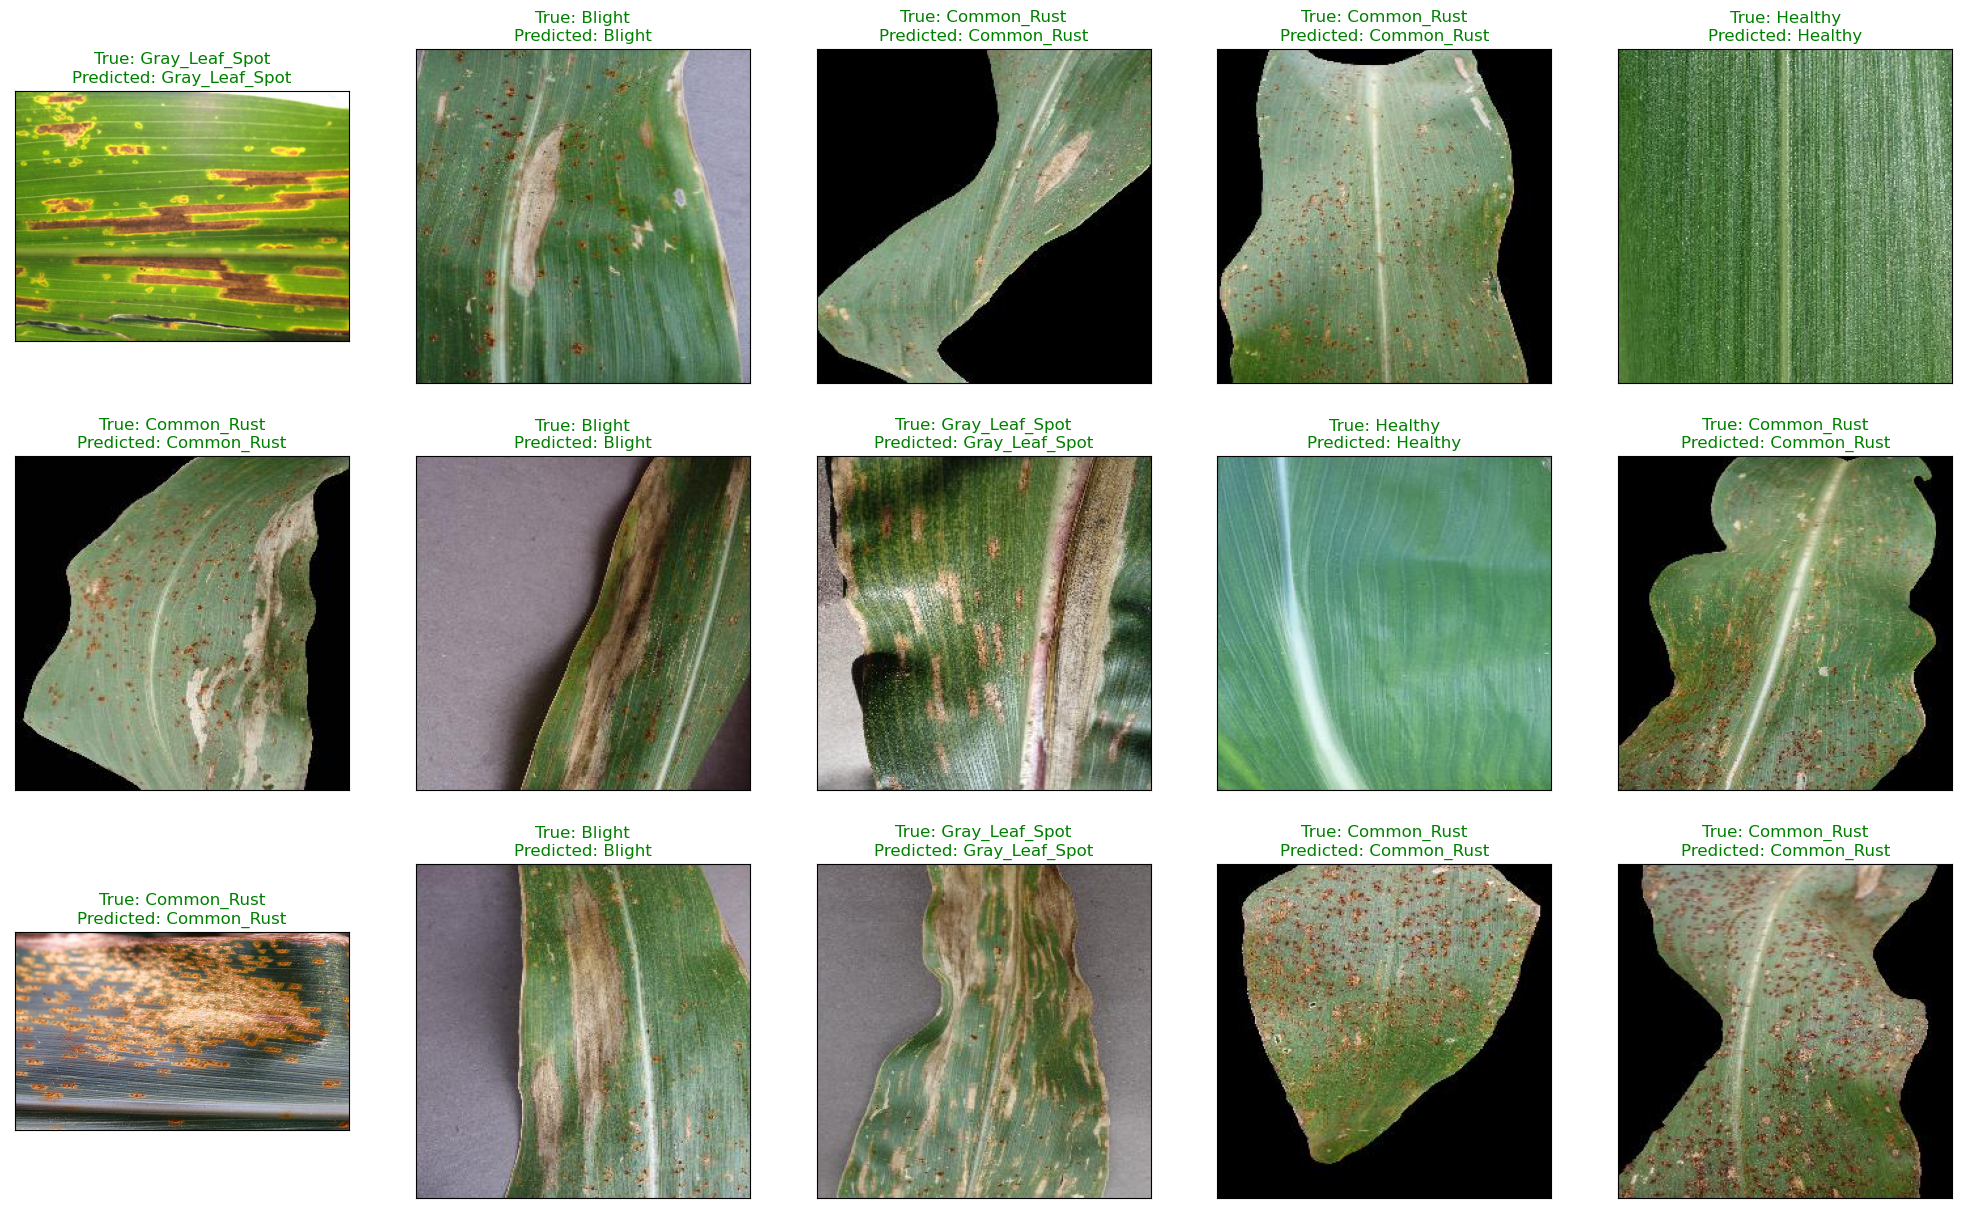

In [29]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [24]:
# classification report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

        Blight       0.96      0.97      0.96       464
   Common_Rust       1.00      0.99      0.99       551
Gray_Leaf_Spot       0.94      0.92      0.93       226
       Healthy       1.00      1.00      1.00       434

      accuracy                           0.98      1675
     macro avg       0.97      0.97      0.97      1675
  weighted avg       0.98      0.98      0.98      1675



In [33]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Blight           0.957265  0.965517  0.961373   464.000000
Common_Rust      0.996357  0.992740  0.994545   551.000000
Gray_Leaf_Spot   0.936937  0.920354  0.928571   226.000000
Healthy          0.995413  1.000000  0.997701   434.000000
accuracy         0.977313  0.977313  0.977313     0.977313
macro avg        0.971493  0.969653  0.970548  1675.000000
weighted avg     0.977266  0.977313  0.977272  1675.000000

In [37]:
# save the model
model.save('/Code/python jupyter/working/myModel.h5')